## Project 3 - ML Approach to Terrain Slope Failure 🌲🌲🌲
- `P(slope Failure) = RF(terrain, lithology/soils, distance)`

In [1]:
#import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split as SPLIT
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./Project3Data/lsm_data2.csv') #Read Data
df.head(2)

,class,slp,sp21,sp11,sp7,rph21,rph11,rph7,diss21,diss11,...,state_dist,local_dist,strm_dist,strm_cost,us_cost,state_cost,local_cost,steve,dspm,drain
0,not,4.85612,-2.560850,-0.799744,-0.338257,18.655701,2.11668,0.248973,0.042033,0.056310,...,6168.839844,0.000000,72.801102,86.637901,2239.270020,14990.799800,65.587799,4,1,1
1,not,4.91437,-0.353561,-0.027847,0.018600,4.788600,1.27792,0.473525,0.392066,0.421253,...,3517.290039,421.070007,534.603027,1660.099976,3253.659912,2088.399902,1857.839966,5,5,2


### Encode Class Variable
```python 
{'not':0, 'slopeD':1} 
```

In [3]:
encode_map = {'not':0, 'slopeD':1} 
df['class'] = df['class'].map(encode_map) #Map Column to Integer Values

In [4]:
df_ls = [df.iloc[:,1:], df.iloc[:,1:32], df.iloc[:,41:], df.iloc[:,33:41], df.iloc[:,33:]]
df_labels =['ALL', 'Terrain', 'Lithology/Soils', 'Distance', 'All Not Terrain'] #Hold Set Features

## Fit Random Forest Model Across Spatial Features
> _**Optimize Slope Failure (Class 1) Predictions**_

In [5]:
rates = [] #2-dimensional array holding fpr + tpr vals
for idx in range(len(df_ls)):
    print('Analysis of {} Features'.format(df_labels[idx]))
    #Split and Stratify Data
    x_train, x_test, y_train, y_test = SPLIT(df_ls[idx], df.iloc[:,0], test_size=.333, stratify=df.iloc[:,0],
                                            random_state=0)
    #Fit Model
    rf = RandomForestClassifier(n_estimators=120, max_depth=5, min_samples_leaf=8)
    rf.fit(x_train, y_train)
    
    #Confusion Matrix
    print(pd.DataFrame(confusion_matrix(y_test, rf.predict(x_test))).rename(columns={0:'Pred_NonFailure', 1:
                                                                          'Pred_Failure'},
                                                        index={0:'True_NonFailure', 1:'True_Failure'}), '\n')
    #ROC + AUC Metric
    fpr, tpr, thres = roc_curve(y_test, rf.predict_proba(x_test)[:,1])
    rates.append([fpr, tpr])
    print('AUC:', auc(fpr, tpr))
    
    #Calc optimized p(y) thres vlalue
    optimal_threshold = thres[np.argmax(tpr - fpr)] 
    print(f"Optimal P(Y) Threshold: {round(optimal_threshold,3)}", '\n____________________________________\n')

Analysis of ALL Features
                 Pred_NonFailure  Pred_Failure
True_NonFailure              467           116
True_Failure                  60           523 

AUC: 0.926876127206235
Optimal P(Y) Threshold: 0.523 
____________________________________

Analysis of Terrain Features
                 Pred_NonFailure  Pred_Failure
True_NonFailure              465           118
True_Failure                  65           518 

AUC: 0.9258081314782178
Optimal P(Y) Threshold: 0.56 
____________________________________

Analysis of Lithology/Soils Features
                 Pred_NonFailure  Pred_Failure
True_NonFailure              198           385
True_Failure                  72           511 

AUC: 0.6759383210401043
Optimal P(Y) Threshold: 0.544 
____________________________________

Analysis of Distance Features
                 Pred_NonFailure  Pred_Failure
True_NonFailure              360           223
True_Failure                 104           479 

AUC: 0.7889310922095154
Optima

### ROC Curves

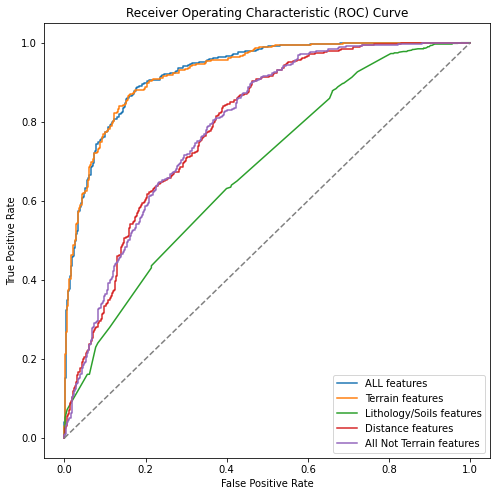

In [6]:
#ROC curve

plt.figure(figsize=(8, 8))

for idx in range(len(rates)):
    plt.plot(rates[idx][0], rates[idx][1], label=df_labels[idx]+' features')

plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()
